In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.stats import sem
from scipy import stats

from scipy.optimize import curve_fit

plt.style.use('classic')

import analyse

# Load data from Lennard-Jones simulation

In [3]:
L = 16.795961913825074  # box length in Lenard-Jones units
N = 4000  # number of particles
rho = N / L**3  # number density in Lenard-Jones units
print(f'Number density: {rho:.3f} LJ units')

Number density: 0.844 LJ units


In [4]:
boltzmann = 1.38064852e-23
sigma_nm = 0.34         # in nm
sigma = sigma_nm * 1e-9 # in m
liter = 1e3             # L's in a m^3
avogadro = 6.022e23     # Avogadro's number, atoms/mole
epsilon_kJ_mol = 0.997  # in kJ/mol
kJ_J = 1e3              # J in a kJ

m = 39.948  # mass of argon in atomic mass units
amu = 1.6605e-27  # atomic mass unit in kg
M = m*amu  # mass of argon in kg

dt = 0.005  # time step in Lennard-Jones units

epsilon = epsilon_kJ_mol * kJ_J/avogadro  # in J
dt_SI = np.sqrt(M * sigma**2 / epsilon)  # LJ time to seconds
print(f'''
Sigma of Argon: {sigma:.4} m
Mass of Argon: {M:.4} kg
Epsilon of Argon: {epsilon:.4} J
LJ time unit in SI units: {dt_SI:.4} s or {dt_SI*1e12:.4} ps
Timestep in SI units: {dt_SI*dt:.4} s or {dt_SI*dt*1e12:.4} ps or {dt_SI*dt*1e12*1e3:.4} fs

''')


Sigma of Argon: 3.4e-10 m
Mass of Argon: 6.633e-26 kg
Epsilon of Argon: 1.656e-21 J
LJ time unit in SI units: 2.152e-12 s or 2.152 ps
Timestep in SI units: 1.076e-14 s or 0.01076 ps or 10.76 fs




In [5]:
df = analyse.thermo_data_as_dataframe(
    filename='../../log-file/lennard-jones/log.lammps',
    time_step=dt
)

df.head()

/Users/jaehyeok/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jaehyeok/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


,Time,Step,Temp,Press,PotEng,KinEng,c_virial
0,0.000,0.0,0.648514,0.469606,-5.267921,0.972528,-0.077733
1,0.005,1.0,0.647146,0.472595,-5.266880,0.970476,-0.073589
2,0.010,2.0,0.647090,0.477217,-5.265713,0.970393,-0.068920
3,0.015,3.0,0.647612,0.481899,-5.264763,0.971175,-0.064678
4,0.020,4.0,0.648336,0.485424,-5.264119,0.972260,-0.061764


In [6]:
print(f'''Number of steps: {len(df)}
Total time: {df['Time'].max()} in LJ units
Total time: {df['Time'].max()*dt_SI*1e9:.2f} ns
''')

Number of steps: 1000001
Total time: 5000.0 in LJ units
Total time: 10.76 ns



In [7]:
T = df['Temp'].mean()  # in Lennard-Jones units
print(f'Temperature: {T:.3f} LJ units')

Temperature: 0.666 LJ units


In [8]:
# In kelvin
T_kelvin = T * epsilon_kJ_mol / boltzmann / avogadro * 1e3
print(f'Temperature in Kelvin: {T_kelvin:.2f} K')

Temperature in Kelvin: 79.88 K


In [9]:
# Density in mol/L converted from Lennard-Jones units
density_mol_L = rho / sigma**3 / avogadro / liter
print(f'Density in mol/L: {density_mol_L:.2f} mol/L')

Density in mol/L: 35.67 mol/L


In [10]:
U = df['PotEng']  # Potential energy
W = df['c_virial']  # Virial

In [11]:
# Pearson correlation coefficient
corr = np.corrcoef(U, W)[0,1]
print(f'Pearson correlation coefficient: {corr:.3f}')

Pearson correlation coefficient: 0.953


In [12]:
def get_corr(W, U, blocks=8, block=0):
    block_size = len(W) // blocks
    start = block * block_size
    end = (block + 1) * block_size
    W_block = W[start:end]
    U_block = U[start:end]
    return np.corrcoef(U_block, W_block)[0,1]
corr = get_corr(W, U, blocks=1)
corr_blocks = [get_corr(W, U, blocks=8, block=block) for block in range(8)]
sem_corr = sem(corr_blocks)
# 67% confidence interval
error_67 = sem_corr * stats.t.ppf((1 + 0.67) / 2, len(corr_blocks) - 1)
print(f'Pearson correlation coefficient: {corr:.3f}({sem_corr*1e3:.0f})')
corr, sem_corr, error_67

Pearson correlation coefficient: 0.953(0)


(0.9534343249942613, 0.00030704469636485036, 0.00032140417113932424)

In [13]:
def get_gamma(W, U, blocks=8, block=0):
    block_size = len(W) // blocks
    start = block * block_size
    end = (block + 1) * block_size
    W_block = W[start:end]
    U_block = U[start:end]
    return np.cov(U_block, W_block)[0,1] / np.var(U_block)
gamma = get_gamma(W, U, blocks=1)
gamma_blocks = [get_gamma(W, U, blocks=8, block=block) for block in range(8)]
sem_gamma = sem(gamma_blocks)
print(f'Gamma: {gamma:.2f}({sem_gamma*1e2:.0f})')
gamma, sem_gamma

Gamma: 4.92(1)


(4.921598138388115, 0.013235238107771817)

In [14]:
# Symmetic gamma
slope = np.sqrt(np.var(W)/np.var(U))
print(f'Symmetric gamma: {slope:.2f}')

Symmetric gamma: 5.16


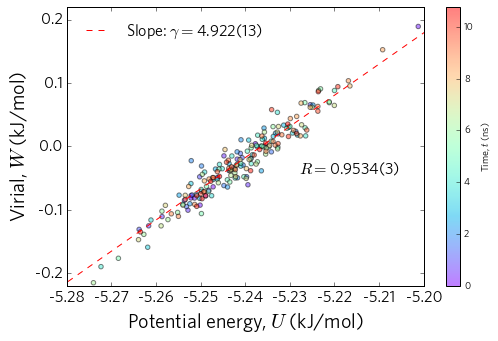

(1000001, 201)

In [41]:
plt.figure(figsize=(8, 5))
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.scatter(
    U[::5000]*epsilon_kJ_mol,
    W[::5000]*epsilon_kJ_mol,
    c=df['Time'][::5000]*dt_SI*1e9,  # in ns
    cmap='rainbow', 
    alpha=0.5)
x_fit = np.linspace(U.min(), U.max(), 10)
intercept = np.mean(W) - gamma * np.mean(U)
plt.plot(
    x_fit*epsilon_kJ_mol, 
    gamma * x_fit*epsilon_kJ_mol + intercept*epsilon_kJ_mol, 
    'r--', label=r'Slope: $\gamma=$' f'{gamma:.3f}({sem_gamma*1e3:.0f})')
# Add text to the plot using relative coordinates
plt.text(0.65, 0.4, r'$R=$' f'{corr:.4f}({sem_corr*1e4:.0f})', transform=plt.gca().transAxes, fontsize=16)
# Aling text to center
# plt.text(0.5, 0.05, r'Single component Lennard-Jones', transform=plt.gca().transAxes, fontsize=14, ha='center')
plt.xlabel(r'Potential energy, $U$ (kJ/mol)',fontsize=20)
plt.ylabel('Virial, $W$ (kJ/mol)',fontsize=20)
plt.xlim(-5.28, -5.20)
plt.ylim(-0.22, 0.22)
plt.colorbar(label=r'Time, $t$ (ns)')
plt.legend(fontsize=16, loc='upper left', frameon=False)
plt.savefig('lennard_jones_WU_scatter.pdf')
plt.show()

len(U), len(U[::5000])

Fit parameters: A=0.483, t1=0.083, t2=2.295
A = 0.483 +- 0.013
t1 = 0.0831 +- 0.0010
t2 = 2.32 +- 0.07


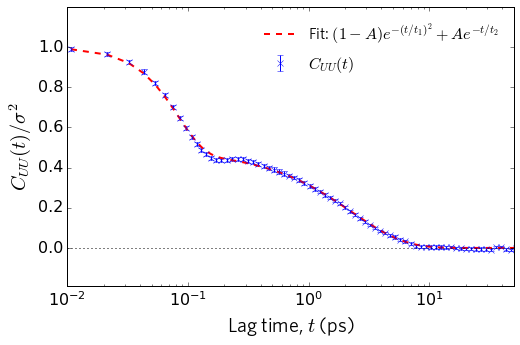

In [40]:
# Compute time-correlation function with error estimates using analyse.time_correlation()
def time_correlation_function_one_block(U, W, blocks=8, block=0):
    block_size = len(W) // blocks
    start = block * block_size
    end = (block + 1) * block_size
    W_block = W[start:end]
    U_block = U[start:end]
    return analyse.time_correlation(U_block, W_block)

def time_correlation_function(U, W, blocks=8):
    # time_correlation = time_correlation_function_one_block(U, W, blocks=blocks, block=0)
    time_correlation_blocks = []
    for block in range(blocks):
        time_correlation_raw = time_correlation_function_one_block(U, W, blocks=blocks,block=block)
        time_correlation = analyse.run_avg_log(time_correlation_raw)
        time_correlation_blocks.append(time_correlation)
    sem_time_correlation = sem(time_correlation_blocks, axis=0)
    time_correlation = np.mean(time_correlation_blocks, axis=0)
    return time_correlation, sem_time_correlation, time_correlation_blocks


C_UU, C_UU_sem, C_UU_blocks = time_correlation_function(U, U, blocks=8)
C_UW, C_UW_sem, _ = time_correlation_function(U, W, blocks=8)
C_WW, C_WW_sem, _ = time_correlation_function(W, W, blocks=8)
times = analyse.run_avg_log(df['Time'])[:len(C_UU)]*dt_SI*1e12

A = 0.45

def exp_initial(t, t0, beta):
    return (1-A)*np.exp(-(t/t0)**beta)+A

def exp_terminal(t, t0):
    return A*np.exp(-(t/t0))

def fit_func(t, A, t1, t2):
    return (1-A)*np.exp(-(t/t1)**2) + A*np.exp(-t/t2)

popt, _ = curve_fit(fit_func, times, C_UU/np.var(U), p0=[0.5, 0.01, 10])

print(f'Fit parameters: A={popt[0]:.3f}, t1={popt[1]:.3f}, t2={popt[2]:.3f}')

plt.figure(figsize=(8, 5))

popts = []
for C in C_UU_blocks:
    # plt.plot(times, C/np.var(U), 'k-', lw=1, alpha=0.2)
    this_popt, _ = curve_fit(fit_func, times, C/np.var(U), p0=popt)
    # plt.plot(times, fit_func(times, *this_popt), 'r--', lw=1, alpha=0.2)
    popts.append(this_popt)
# SEM of the fit parameters
popts = np.array(popts)
sem_popts = sem(popts, axis=0)
print(f'A = {popts[:,0].mean():.3f} +- {sem_popts[0]:.3f}')
print(f't1 = {popts[:,1].mean():.4f} +- {sem_popts[1]:.4f}')
print(f't2 = {popts[:,2].mean():.2f} +- {sem_popts[2]:.2f}')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.errorbar(times, C_UU/np.var(U), C_UU_sem/np.var(U), fmt='x', label=r'$C_{UU}(t)$')
plt.plot(times, fit_func(times, *popt), 'r--', lw=2, label=r'Fit: $(1-A)e^{-(t/t_1)^2} + Ae^{-t/t_2}$')
plt.xscale('log')
plt.xlim(0.01, 50)
plt.ylim(-0.19, 1.199)
plt.xlabel('Lag time, $t$ (ps)',fontsize=20)
plt.ylabel(r'$C_{UU}(t)/\sigma^2$',fontsize=20)
#plt.text(0.5, 0.05, r'Single component Lennard-Jones', transform=plt.gca().transAxes, fontsize=14, ha='center')
plt.xticks(fontname="DejaVu Sans",fontsize=16)
plt.yticks(fontname="DejaVu Sans",fontsize=16)
plt.plot([0.01, 50], [0, 0], 'k:')  # Dotted line at y=0
# One point per data point
plt.legend(frameon=False, fontsize=16, numpoints=1)
plt.savefig('lennard_jones_CUU.pdf')
plt.show()

In [21]:
# Function that computes pearson correlation coefficient and gamma for a given boxcar width

def compute_corr_gamma_block(U, W, boxcar_width, blocks=8, block=0):
    block_size = len(W) // blocks
    start = block * block_size
    end = (block + 1) * block_size
    W_block = W[start:end]
    U_block = U[start:end]
    U_boxcar = uniform_filter1d(U_block, size=boxcar_width)
    W_boxcar = uniform_filter1d(W_block, size=boxcar_width)
    U_boxcar = U_boxcar[boxcar_width:-boxcar_width]
    W_boxcar = W_boxcar[boxcar_width:-boxcar_width]
    corr = np.corrcoef(U_boxcar, W_boxcar)[0,1]
    gamma = np.cov(U_boxcar, W_boxcar)[0,1] / np.var(U_boxcar)
    return corr, gamma

def compute_corr_gamma(U, W, boxcar_width, blocks=8):
    #corr, gamma = compute_corr_gamma_block(U, W, boxcar_width, blocks=blocks, block=0)
    corr_blocks = []
    gamma_blocks = []
    for block in range(blocks):
        corr, gamma = compute_corr_gamma_block(U, W, boxcar_width, blocks=blocks, block=block)
        corr_blocks.append(corr)
        gamma_blocks.append(gamma)
    corr = np.mean(corr_blocks)
    gamma = np.mean(gamma_blocks)
    sem_corr = sem(corr_blocks)
    sem_gamma = sem(gamma_blocks)
    return corr, gamma, sem_corr, sem_gamma

taus = np.unique(np.logspace(0, 4, 32).astype(int))
gammas = []
corrs = []
gamma_sems = []
corr_sems = []
for tau in taus:
    corr, gamma, sem_corr, sem_gamma = compute_corr_gamma(U, W, tau, blocks=8)
    gammas.append(gamma)
    corrs.append(corr)
    gamma_sems.append(sem_gamma)
    corr_sems.append(sem_corr)

# taus, gammas, corrs, gamma_sems, corr_sems

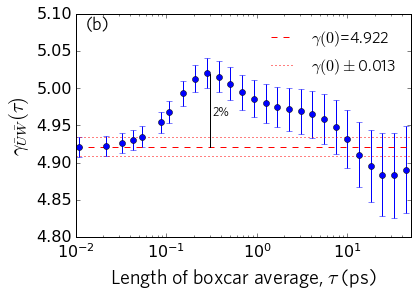

(2.2597373979783777, 4.971652904226792, 0.028726188593356405)

In [54]:
# Plot gamma as a function of boxcar width
dt_step = df.Step[1] - df.Step[0]
plt.figure()
plt.errorbar(taus*dt_SI*1e12*dt, gammas, yerr=gamma_sems, fmt='o')
gamma = get_gamma(W, U, blocks=1)
sem_gamma = sem([get_gamma(W, U, blocks=8, block=block) for block in range(8)])
plt.hlines(gamma, 0.01, 50, 'r', linestyles='--', label=r'$\gamma(0)$=' f'{gamma:0.4}')
plt.hlines(gamma+sem_gamma, 0.01, 50, 'r', linestyles=':', label=r'$\gamma(0) \pm$' f'{sem_gamma:0.2}')
plt.hlines(gamma-sem_gamma, 0.01, 50, 'r', linestyles=':')

# Add a horizontal line indicating 1% change of gamma i.e. 0.05
plt.plot([0.3, 0.3], [4.921, 4.921*1.02], 'k-')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.text(0.32, 4.924*1.009, '2%', fontsize=12, va='center')

plt.xscale('log')
plt.ylim(4.8, 5.1)
plt.xlim(1e-2, 50)
#plt.text(0.5, 0.05, r'Single component Lennard-Jones', transform=plt.gca().transAxes, fontsize=14, ha='center')
plt.xlabel(r'Length of boxcar average, $\tau$ (ps)',fontsize=20)
plt.ylabel(r'$\gamma_{\bar U\bar W}(\tau)$',fontsize=20)
plt.text(0.03, 0.93, '(b)', transform=plt.gca().transAxes, fontsize=18)
plt.legend(frameon=False,fontsize=16)
plt.xticks(fontname="DejaVu Sans",fontsize=16)
plt.yticks(fontname="DejaVu Sans",fontsize=16)
plt.savefig('lennard_jones_gamma.pdf', bbox_inches='tight')
plt.show()

tmp = taus*dt_SI*1e12*dt
tmp[16], gammas[16], gamma_sems[16]

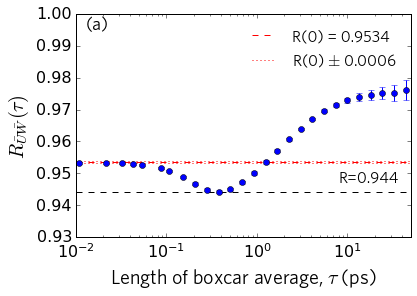

(9.985887168209212, 0.9728474490189019, 0.0008669032494694411)

In [53]:
corr = get_corr(W, U, blocks=1)
sem_corr = sem([get_corr(W, U, blocks=8, block=block) for block in range(8)])

# Plot Pearson correlation coefficient as a function of boxcar width
plt.figure()
plt.rcParams.update({
    'font.family': 'DejaVu Sans',   # Default font
    #'font.family': 'Whitney Book', # Actual font used in the paper (needs to install font first)
    'axes.unicode_minus': False
})
plt.errorbar(taus*dt_SI*1e12*dt, corrs, yerr=corr_sems, fmt='o')
plt.hlines(corr, 0.01, 50, 'r', linestyles='--', label=r'R(0) = ' f'{corr:0.4}')
plt.hlines(corr+sem_corr, 0.01, 50, 'r', linestyles=':', label=r'R(0) $\pm$ 0.0006')
plt.hlines(corr-sem_corr, 0.01, 50, 'r', linestyles=':')
plt.hlines(0.944, 0.01, 50, 'k', linestyles='--')
plt.text(8, 0.9475, r'R=0.944',fontsize=16)
#plt.text(0.5, 0.05, r'Single component Lennard-Jones', transform=plt.gca().transAxes, fontsize=16, ha='center')
plt.xscale('log')
plt.text(0.03, 0.93, '(a)', transform=plt.gca().transAxes, fontsize=18)
plt.ylim(0.93, 1)
plt.xlim(1e-2, 50)
plt.xticks(fontname="DejaVu Sans",fontsize=16)
plt.yticks(fontname="DejaVu Sans",fontsize=16)
plt.xlabel(r'Length of boxcar average, $\tau$ (ps)',fontsize=20)
plt.ylabel(r'$R_{\bar U\bar W}(\tau)$',fontsize=20)
plt.legend(frameon=False,fontsize=16)
plt.savefig('lennard_jones_corr.pdf', bbox_inches='tight')
plt.show()

tmp = taus*dt_SI*1e12*dt
sel=21
tmp[sel], corrs[sel], corr_sems[sel]

In [30]:
## Gamma comparison with error estimates
gamma_long = 4.982
gamma_long_sem = 0.030
gamma_short = 4.924
gamma_short_sem = 0.013

gamma_rel_change = (gamma_long - gamma_short) / gamma_short
print(f'Relative change in gamma: {gamma_rel_change:.3f} ')

gamma_rel_change_sem = np.sqrt(gamma_long_sem**2 + gamma_short_sem**2) / gamma_short
print(f'Error in relative change in gamma: {gamma_rel_change_sem:.3f} ')

Relative change in gamma: 0.012 
Error in relative change in gamma: 0.007 
